In [28]:
# imports
import pandas_datareader as pdr
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import statsmodels.api as smapi
import statsmodels.tsa as tsa
import numpy as np
import scipy as sp
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [259]:
class DATA():
    # economic data
    
    @classmethod
    def get_commod_data(cls,*args,**kwargs):
        data = {'oil': cls.get_oil_data, 'gasoline':cls.get_gasoline_data,
                'natgas': cls.get_natgas_data, 'corn':cls.get_corn_data,
                'wheat':cls.get_wheat_data}
        
        results = {x: data[x](*args,**kwargs) for x in data.keys()}
        return results
    
    #commodities data
    @staticmethod
    def get_oil(*args,**kwargs):
        data = quandl.get("CHRIS/CME_QM1")
        return data
    @staticmethod
    def get_gasoline(*args,**kwargs):
        data = quandl.get("CHRIS/ICE_N1")
        return data
    @staticmethod
    def get_natgas(*args, **kwargs):
        data = quandl.get("CHRIS/CME_NG2")
    @staticmethod
    def get_corn(*args, **kwargs):
        data = quandl.get("CHRIS/LIFFE_EMA2")
        return data
    @staticmethod
    def get_wheat(*args, **kwargs):
        data = quandl.get("CHRIS/CME_W4")
        return data
    # Economic data
    @staticmethod
    def get_mich_cons_sent(*args, **kwargs):
        data = quandl.get('UMICH/SOC1')
        return data['Index']
    @staticmethod
    def get_fred_gdp(*args,**kwargs):
        data = quandl.get("FRED/GDP")
        return data
    # interest rate data
    @staticmethod
    def get_us_yields(*args,**kwargs):
        data = quandl.get("USTREASURY/YIELD")
        return data
    
class STATS():
    @staticmethod
    def Demean(data,*args,**kwargs):
        dem_data = data.subtract(data.mean())
        return dem_data
    
    @staticmethod
    def two_sample_test(data,*args,**kwargs):
        # method to split data into two equal half samples and run some simple comparisons to check for stationarity
        # note: it's very likely we will not be able to fully prove it but if we can get reasonably close it will save
        # us alot of work
        ndim = len(data)
        data_fh = data[:int(ndim/2)]
        data_sh =data[int(ndim/2):]
        mean_fh = data_fh.mean()
        mean_sh = data_sh.mean()
        var_fh = data_fh.var()
        var_sh = data_sh.var()
        # getting the 
        
        results = {'mu_fh':mean_fh,'mu_sh':mean_sh,'var_fh': var_fh, 'var_sh': var_sh}
        return pd.Series(results)
    
    @staticmethod
    def ADFuller(data,*args,**kwargs):
        # method to run augmented dickey-fuller test for unit-root
        # if we can reject the null our series is probably weakly stationary
        # the default is that the series is to run with a constant (i.e. non-zero mean)
        # but we can demean the series first
        # we can put a max-lag after the fact
        # note that lag convention is pythonic i.e. lag=0 means an AR(1)
        
        def_args = {}
        def_args['maxlag']=kwargs.get('maxlag',None)
        def_args['regression']=kwargs.get('regression','c')
        def_args['autolag']=kwargs.get('autolag','AIC')
        def_args['store']=kwargs.get('store',False)
        def_args['regresults']=kwargs.get('regresults',True)
        
        results = tsa.stattools.adfuller(data.values.reshape(-1,),**def_args)
        return results
    
    @staticmethod
    def compute_acf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
    
        def_args = {}
        def_args['unbiased']=kwargs.get('unbiased',False)
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['qstat']=kwargs.get('qstat',False)
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.acf(data,**def_args)
        return results
    
    @staticmethod
    def compute_pacf(data,*args,**kwargs):
        # return the sample autocorrelation function
        # by default return the confidence intervals
        def_args = {}
        def_args['nlags']=kwargs.get('nlags',36)
        def_args['method']=kwargs.get('method','ywunbiased')
        def_args['alpha']=kwargs.get('alpha',0.05)
        
        results = tsa.stattools.pacf(data,**def_args)
        return results
    
    @staticmethod
    def AR_model(data,*args,**kwargs):
        def_args = {}
        def_args['dates'] = kwargs.get('dates',None)
        def_args['freq'] = kwargs.get('freq',None)
        def_args['missing'] = kwargs.get('missing',None)
        model= tsa.ar_model.AR(data.values.reshape(-1,),**def_args)
        return model
                
    @staticmethod
    def ARMA_model(data,maxp=3,maxq=3,*args,**kwargs):
        plags=range(maxp+1)
        qlags=range(maxq+1)
        p_q = [(x,y) for x in plags for y in qlags]
        all_models = {'arma({0},{1})'.format(x[0],x[1]):tsa.arima_model.ARMA(data,x,) for x in p_q}
        return all_models
        
        
    @staticmethod
    def ARIMA_model(data,maxp=3,maxq=3,maxd=1,*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        all_models = {'arima({0},{1},{2})'.format(x[0],x[1],x[2]):tsa.arima_model.ARIMA(endog=data,order=x,) for x in p_d_q}
        return all_models
        
    @staticmethod
    def SARIMA_model(data,maxp=3,maxq=3,maxd=1,maxP=0,maxD=0,maxQ=0,maxs=0,*args,**kwargs):
        plags=range(maxp+1)
        dlags=range(maxd+1)
        qlags=range(maxq+1)
        p_d_q = [(x,z,y) for x in plags for z in dlags for y in qlags]
        
        Plags=range(maxP+1)
        Dlags=range(maxD+1)
        Qlags=range(maxQ+1)
        slags=range(maxs+1)
        P_D_Q_s = [(a,b,c,d) for a in Plags for b in Dlags for c in Qlags for d in slags]
        
        all_models = {'sarima(({0},{1},{2})X({3},{4},{5},{6})'.format(x[0],x[1],x[2]):tsa.arima_model.SARIMAX(data,None,
                                                                                                              order=x,seasonal_order=y) 
                      for x in p_d_q for y in P_D_Q_s}

        
    
class PLOTTERS():
    @staticmethod
    def line_plot(data,xlabel=None,ylabel=None, *args,**kwargs):
        fig_ = plt.gcf()
        ax_ = data.plot()
        return fig_,ax_
        
        
        


##### Raw script

### Getting the data

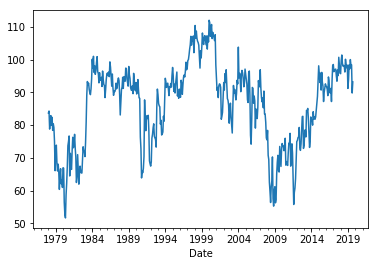

In [277]:
# Getting the the data
data_cons = DATA.get_mich_cons_sent().truncate(before=datetime.datetime(1978,1,30))
data_cons.plot()

Notes: this is consumer sentiment data. The mean appears to be pretty stable and there are no obvious seasonal or trending patterns over the data

### Estimating and sample and partial ACFs

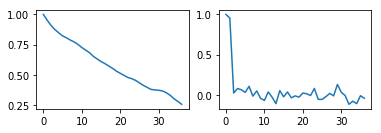

In [278]:
data_acf =STATS.compute_acf(data_cons)
data_pacf=STATS.compute_pacf(data_cons)
plt.subplot(221)
plt.plot(data_acf[0])
plt.subplot(222)
plt.plot(data_pacf[0])

Sample and partial autocorrelation functions plotted above. The sample autocorrelation suggests that there is persistence in the data but the PACF suggests that getting one lag incorporated reduces the other lags to near zero

### Stationarity test

In [337]:
simple_test = STATS.two_sample_test(data_cons)
# get up to two lags
adfuller_test_lag1 = STATS.ADFuller(data_cons,maxlag=1)
adfuller_test_lag2 = STATS.ADFuller(data_cons,maxlag=2)
adfuller_test_lag3 = STATS.ADFuller(data_cons,maxlag=3)
adfuller_test_lag4 = STATS.ADFuller(data_cons,maxlag=4)

adfuller_fulltest = STATS.ADFuller(data_cons)

In [338]:
simple_test

mu_fh      85.760400
mu_sh      86.729880
var_fh    157.506739
var_sh    162.534024
dtype: float64

Notes: hard to tell much from this simple test. Probably will need to add some simple pair-mean / pair-variance tests but neither the means nor std. deviation look drastically different so this might suggest the data is near stationary - which is good!

In [348]:
adfuller_test_lag1

(-3.451318422837428,
 0.009328982189318298,
 {'1%': -3.443496379464, '5%': -2.8673378563200003, '10%': -2.569858036},
 <statsmodels.tsa.stattools.ResultsStore at 0x1fad09feb38>)

In [345]:
adfuller_test_lag2

(-3.020306731000242,
 0.03304103460390658,
 {'1%': -3.4435494520411605,
  '5%': -2.8673612117611267,
  '10%': -2.5698704830567247},
 <statsmodels.tsa.stattools.ResultsStore at 0x1fad09fea90>)

In [346]:
adfuller_test_lag3

(-3.020306731000242,
 0.03304103460390658,
 {'1%': -3.4435494520411605,
  '5%': -2.8673612117611267,
  '10%': -2.5698704830567247},
 <statsmodels.tsa.stattools.ResultsStore at 0x1facb1e0278>)

In [347]:
adfuller_test_lag4

(-3.451318422837428,
 0.009328982189318298,
 {'1%': -3.443496379464, '5%': -2.8673378563200003, '10%': -2.569858036},
 <statsmodels.tsa.stattools.ResultsStore at 0x1facd4837b8>)

In [282]:
adfuller_fulltest

(-2.377886795443703,
 0.14807520586913447,
 {'1%': -3.4436298692815304,
  '5%': -2.867396599893435,
  '10%': -2.5698893429241916},
 <statsmodels.tsa.stattools.ResultsStore at 0x1facf06d278>)

In [349]:
adfuller_fulltest[-1].usedlag

5

Notes: this is decent result. A simple 2-lag (AR(3)) Augmented Dickey-Fuller test suggests that we can reject the null hypothesis that there is a unit root. A full test allowing the model to find the 'best-fit' suggests we cannot reject the null at even the 10% which is potentially a problem. The full test uses 5 lags which I think translates in python convention to an AR(6)
- so not definitive but it seems reasonable that the data is close but not exactly stationary

### Fitting an AR model

In [294]:
ddata_cons = STATS.Demean(data_cons)
# we don't actually have to demean since the code can do it but it seemed easier to visualize
ar_model_opt = STATS.AR_model(ddata_cons)
ar_fit = ar_model_opt.fit()

ar_model_1 = STATS.AR_model(ddata_cons)
ar_fit_1 = ar_model_1.fit(maxlag=1)

ar_model_2 = STATS.AR_model(ddata_cons)
ar_fit_2 = ar_model_2.fit(maxlag=2)

ar_model_3 = STATS.AR_model(ddata_cons)
ar_fit_3 = ar_model_3.fit(maxlag=3)

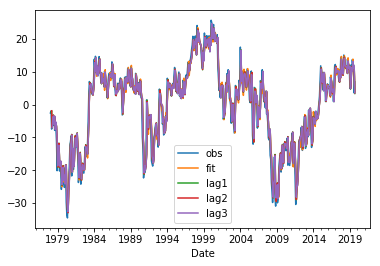

In [295]:
fitvalues = pd.Series(index=ddata_cons.index[18:],data=ar_fit.fittedvalues)
fitvalues_1 = pd.Series(index=ddata_cons.index[1:],data=ar_fit_1.fittedvalues)
fitvalues_2 = pd.Series(index=ddata_cons.index[2:],data=ar_fit_2.fittedvalues)
fitvalues_3 = pd.Series(index=ddata_cons.index[3:],data=ar_fit_3.fittedvalues)

plot_data = pd.DataFrame({'obs':ddata_cons,'fit':fitvalues, 'lag1':fitvalues_1,
                         'lag2':fitvalues_2,'lag3':fitvalues_3})
plot_data.plot()

In [296]:
print('opt:{0} lag1:{1} lag2:{2} lag3:{3}'.format(ar_fit.aic,ar_fit_1.aic,ar_fit_2.aic,ar_fit_3.aic))

opt:2.722373711949147 lag1:2.7032732502554344 lag2:2.7088264677657437 lag3:2.7029086845812667


An AR model seems to fit pretty well. The optimal fit found by minimizing the AIC appears to choose up to 19 lags. But even 1 lag seems to get pretty close.

### Fitting ARMA model

In [329]:
# this gets all the arma models
# we then have to fit each one and get the AIC
all_arma = STATS.ARMA_model(ddata_cons,maxp=10,maxq=1)
arma_aic = pd.Series({imodel: all_arma[imodel].fit().aic for imodel in all_arma})


In [330]:
arma_aic

arma(0,0)     3967.252119
arma(0,1)     3483.744131
arma(1,0)     2777.523949
arma(1,1)     2779.246814
arma(2,0)     2779.298125
arma(2,1)     2781.518766
arma(3,0)     2777.463503
arma(3,1)     2775.208578
arma(4,0)     2777.542050
arma(4,1)     2777.096157
arma(5,0)     2778.970738
arma(5,1)     2779.603149
arma(6,0)     2775.638382
arma(6,1)     2777.159437
arma(7,0)     2777.544256
arma(7,1)     2778.552032
arma(8,0)     2778.394252
arma(8,1)     2780.117704
arma(9,0)     2779.394430
arma(9,1)     2780.435007
arma(10,0)    2779.876116
arma(10,1)    2781.449739
dtype: float64

In [331]:
arma_aic[arma_aic==arma_aic.min()]

arma(3,1)    2775.208578
dtype: float64

In [332]:
opt_model=all_arma['arma(3,1)'].fit()

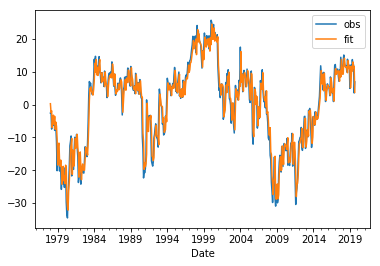

In [333]:
plot_data = pd.DataFrame({'obs': ddata_cons, 'fit':opt_model.fittedvalues})
plot_data.plot()

Notes: An ARMA(3,1) seems to be the optimal fit but it's likely a pretty flat surface. One problem I'm noticing is that attemps to do more than a MA(1) seem to be problematic i.e. the optimizer doesn't converge with current defaults. We can try to increase the number of iterations but it might not be worth it.

### Fitting ARIMA model

In [320]:
# this gets all the arima models
# we then have to fit each one and get the AIC
all_arima = STATS.ARIMA_model(ddata_cons,maxp=10,maxq=0,maxd=2)
arima_aic = pd.Series({imodel: all_arima[imodel].fit().aic for imodel in all_arima})


In [321]:
arima_aic

arima(0,0,0)     3967.252119
arima(0,1,0)     2780.393807
arima(0,2,0)     3142.932438
arima(1,0,0)     2777.523949
arima(1,1,0)     2781.416207
arima(1,2,0)     3020.036767
arima(2,0,0)     2779.298125
arima(2,1,0)     2777.555323
arima(2,2,0)     2959.152827
arima(3,0,0)     2777.463503
arima(3,1,0)     2776.405290
arima(3,2,0)     2920.123870
arima(4,0,0)     2777.542050
arima(4,1,0)     2777.182978
arima(4,2,0)     2907.345449
arima(5,0,0)     2778.970738
arima(5,1,0)     2772.372161
arima(5,2,0)     2878.162967
arima(6,0,0)     2775.638382
arima(6,1,0)     2774.370865
arima(6,2,0)     2869.107260
arima(7,0,0)     2777.544256
arima(7,1,0)     2774.601558
arima(7,2,0)     2849.099973
arima(8,0,0)     2778.394252
arima(8,1,0)     2776.038294
arima(8,2,0)     2834.563856
arima(9,0,0)     2779.394430
arima(9,1,0)     2777.134665
arima(9,2,0)     2833.987160
arima(10,0,0)    2779.876116
arima(10,1,0)    2777.825658
arima(10,2,0)    2828.357718
dtype: float64

In [323]:
arima_aic[arima_aic==arima_aic.min()]

arima(5,1,0)    2772.372161
dtype: float64

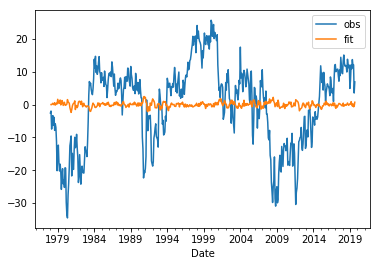

In [325]:
optarima = all_arima['arima(5,1,0)'].fit()
plot_data = pd.DataFrame({'obs': ddata_cons, 'fit':optarima.fittedvalues})
# the plot is definitely wrong
# I don't think the fittedvalues attribute for ARIMA models is correct
# no documentation on it

plot_data.plot()

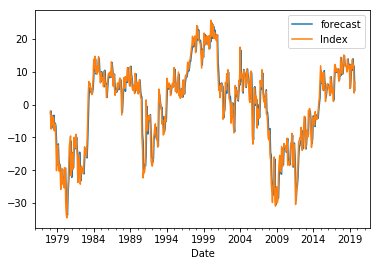

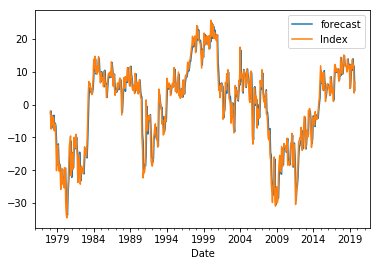

In [326]:
optarima.plot_predict()

Notes: ok.. so for ARIMA models (and probably SARIMA which I won't do yet) we want to use the built in plot-predict function.
We should compare the three model types by mean-square error. It all looks really close so I doubt we'll have a clear winner.

In [327]:
data_cons

Date
1978-01-31     83.7
1978-02-28     84.3
1978-03-31     78.8
1978-04-30     81.6
1978-05-31     82.9
1978-06-30     80.0
1978-07-31     82.4
1978-08-31     78.4
1978-09-30     80.4
1978-10-31     79.3
1978-11-30     75.0
1978-12-31     66.1
1979-01-31     72.1
1979-02-28     73.9
1979-03-31     68.4
1979-04-30     66.0
1979-05-31     68.1
1979-06-30     65.8
1979-07-31     60.4
1979-08-31     64.5
1979-09-30     66.7
1979-10-31     62.1
1979-11-30     63.3
1979-12-31     61.0
1980-01-31     67.0
1980-02-29     66.9
1980-03-31     56.5
1980-04-30     52.7
1980-05-31     51.7
1980-06-30     58.7
              ...  
2017-04-30     97.0
2017-05-31     97.1
2017-06-30     95.0
2017-07-31     93.4
2017-08-31     96.8
2017-09-30     95.1
2017-10-31    100.7
2017-11-30     98.5
2017-12-31     95.9
2018-01-31     95.7
2018-02-28     99.7
2018-03-31    101.4
2018-04-30     98.8
2018-05-31     98.0
2018-06-30     98.2
2018-07-31     97.9
2018-08-31     96.2
2018-09-30    100.1
2018-10-31     

In [276]:
data_cons.to_csv('c:/Users/Ui-Wing/Downloads/data.csv')